In [1]:
import os
import json
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from recsys.models import DeepFM
from recsys.data.movielens import MovielensDataset
from recsys.utils.metrics import evaluate
from recsys.utils import recommender, visualizer

In [2]:
with open("../configs/config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
with open(config["data"]["experiment_group"], "r") as f:
    experiment_group = json.load(f)
experiment_group[DeepFM.model_name] = []
    
with open(config["data"]["num_sparse_features"], "r") as f:
    num_sparse_features = json.load(f)
    
with open(config["data"]["dense_features"], "r") as f:
    dense_features = json.load(f)

train = pd.read_parquet(config["data"]["train"])
test = pd.read_parquet(config["data"]["test"])

In [3]:
# Define Dataset
train_ds = MovielensDataset(train, list(num_sparse_features.keys()), dense_features)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config["training"]["batch_size"], shuffle=True)

test_ds = MovielensDataset(test, list(num_sparse_features.keys()), dense_features)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test["item_id"].nunique(), shuffle=False)

device = torch.device(config["training"]["device"])
model = DeepFM(num_sparse_features=num_sparse_features, dense_features=dense_features, **config["models"][DeepFM.model_name])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["training"]["lr"])
print(model)

DeepFM(
  (sparse_arch): ModuleDict(
    (user_id): Embedding(943, 16)
    (item_id): Embedding(1682, 16)
    (gender): Embedding(2, 16)
    (occupation): Embedding(21, 16)
    (genre): Embedding(19, 16)
  )
  (dense_arch): Linear(in_features=1, out_features=16, bias=False)
  (deep): Deep(
    (mlp): Sequential(
      (0): Linear(in_features=96, out_features=32, bias=False)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=False)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=False)
      (5): ReLU()
    )
  )
  (fm): FM()
  (classifier): Linear(in_features=49, out_features=1, bias=True)
)


Epoch 10/10: 100%|█████████████████████████████████████████| 5747/5747 [00:49<00:00, 115.87it/s, auc=0.8858, logloss=0.28]


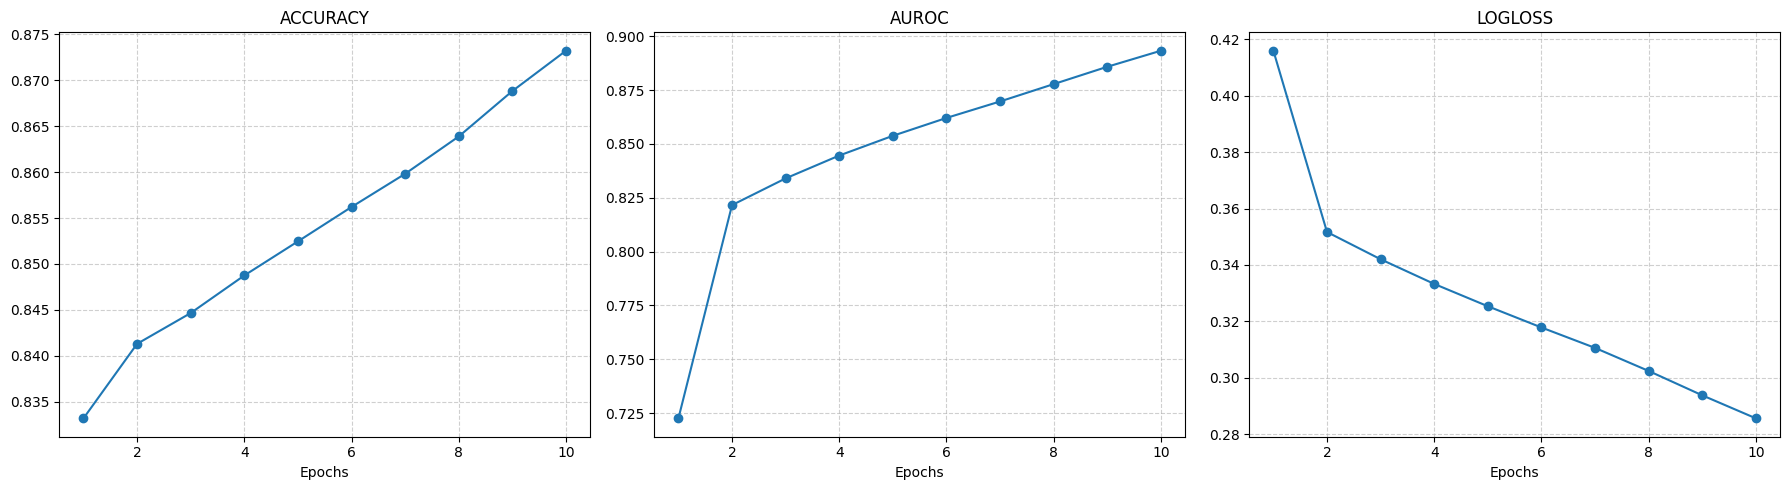

In [4]:
history = recommender.train(model, train_loader, optimizer, device, config["training"]["epochs"])
visualizer.plot_history(history)

Recommend (deepfm): 100%|██████████████████████████████████████████████████| 943/943 [00:12<00:00, 73.13it/s, user_id=942]


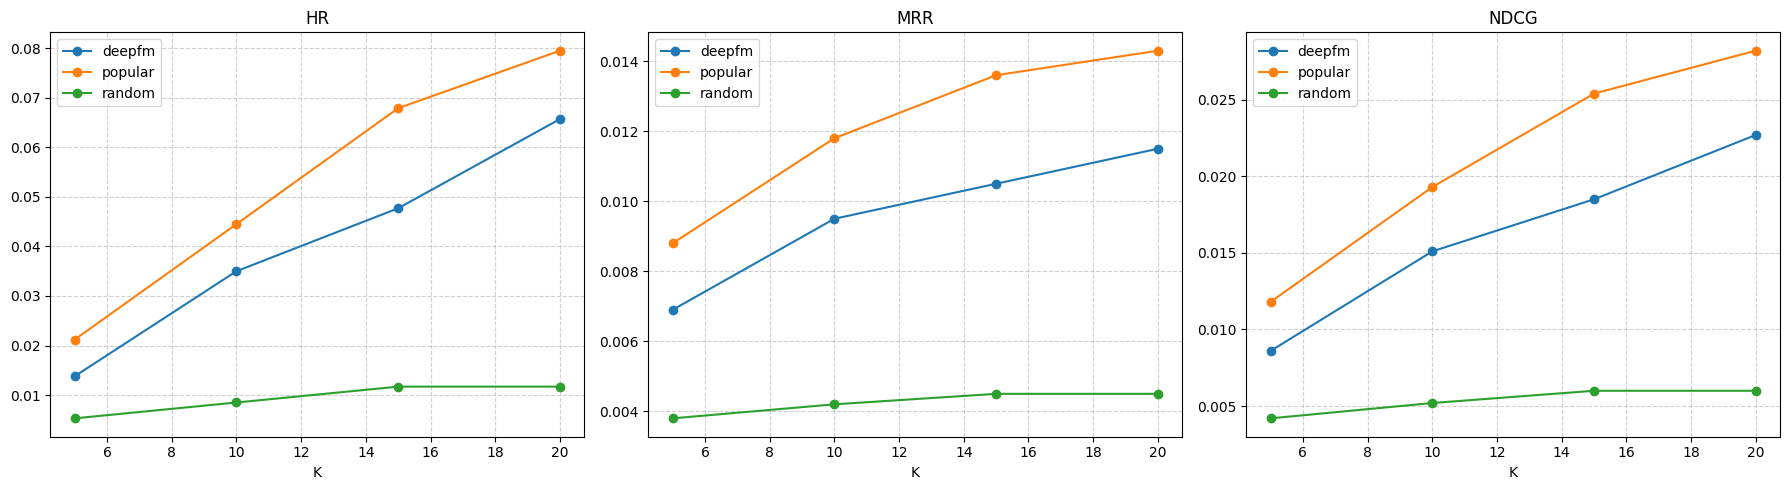

In [5]:
os.makedirs("results", exist_ok=True)
user_recommendations = recommender.inference(model, device, test_loader)
with open(f"results/{model.model_name}.json", "w") as f:
    json.dump({
        k: v.tolist() for k, v in user_recommendations.items()
    }, f)

ks = [5, 10, 15, 20]
_test = test[test["rating"]==1]
recommendations = {
    "popular": np.array(experiment_group["popular"]),
    "random": np.array(experiment_group["random"]),
    model.model_name: user_recommendations
}
results = evaluate(_test, recommendations, ks)
visualizer.plot_metrics(results)